# Training an MLP on Time Series Data
This notebook demonstrates how to train a Multi-Layer Perceptron (MLP) on synthetic time series data using the ThreeWToolkit, for the time series regression task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from ThreeWToolkit.preprocessing import normalize, windowing
from ThreeWToolkit.trainer.trainer import ModelTrainer, TrainerConfig
from ThreeWToolkit.models.mlp import MLPConfig
from ThreeWToolkit.dataset import ParquetDataset
from ThreeWToolkit.core.base_dataset import ParquetDatasetConfig

In [2]:
dataset_path = Path("dataset")

# create and load
ds_config = ParquetDatasetConfig(
    path=dataset_path, clean_data=True, download=False, target_class=[0, 1, 2]
)

ds = ParquetDataset(ds_config)
ds[19]
len(ds)


760

In [3]:
window_size = 100
mlp_config = MLPConfig(
    input_size=window_size,
    hidden_sizes=(64, 32),
    output_size=1,
    random_seed=11,
    activation_function="relu",
    regularization=None,
)

trainer_config = TrainerConfig(
    optimizer="adam",
    criterion="cross_entropy",
    batch_size=16,
    epochs=100,
    seed=11,
    config_model=mlp_config,
    learning_rate=0.001,
    device="cuda" if torch.cuda.is_available() else "cpu",
    cross_validation=False,
    shuffle_train=True
)

trainer = ModelTrainer(trainer_config)
print(trainer.model)

MLP(
  (activation_func): ReLU()
  (model): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [4]:
ds[0]["signal"].columns

Index(['ABER-CKGL', 'ABER-CKP', 'ESTADO-DHSV', 'ESTADO-M1', 'ESTADO-M2',
       'ESTADO-PXO', 'ESTADO-SDV-GL', 'ESTADO-SDV-P', 'ESTADO-W1', 'ESTADO-W2',
       'ESTADO-XO', 'P-ANULAR', 'P-JUS-CKGL', 'P-JUS-CKP', 'P-MON-CKP',
       'P-PDG', 'P-TPT', 'QGL', 'T-JUS-CKP', 'T-MON-CKP', 'T-PDG', 'T-TPT'],
      dtype='object')

In [5]:
selected_col = "T-TPT"
n_events = 25
x_train = []
y_train = []
dfs = []

for event in ds:
    #normalized_signal = normalize(event["signal"][selected_col])
    windowed_signal = windowing(
        event["signal"][selected_col],
        window="hann",
        window_size=window_size,
        overlap=0.5,
        pad_last_window=True,
    )
    windowed_signal.drop(columns=["win"], inplace=True)
    windowed_signal["label"] = np.unique(event["label"]["class"])[0]
    dfs.append(windowed_signal)
    # windowed_label = np.repeat(
    #     np.unique(event["label"]["class"]), windowed_signal.shape[0]
    # )
    # y_train.extend(windowed_label)
    # if len(dfs) >= n_events:
    #     break
    

In [6]:
dfs_final = pd.concat(dfs, ignore_index=True, axis=0)

In [7]:
dfs_final


,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10,...,val_92,val_93,val_94,val_95,val_96,val_97,val_98,val_99,val_100,label
0,0.0,0.000931,0.003719,0.008354,0.014817,0.023083,0.033120,0.044887,0.058338,0.073420,...,0.073420,0.058338,0.044887,0.033120,0.023083,0.014817,0.008354,0.003719,0.000931,2
1,0.0,0.000931,0.003719,0.008354,0.014817,0.023083,0.033120,0.044887,0.058338,0.073420,...,0.073420,0.058338,0.044887,0.033120,0.023083,0.014817,0.008354,0.003719,0.000931,2
2,0.0,0.000931,0.003719,0.008354,0.014817,0.023083,0.033120,0.044887,0.058338,0.073420,...,0.073420,0.058338,0.044887,0.033120,0.023083,0.014817,0.008354,0.003719,0.000931,2
3,0.0,0.000931,0.003719,0.008354,0.014817,0.023083,0.033120,0.044887,0.058338,0.073420,...,0.073420,0.058338,0.044887,0.033120,0.023083,0.014817,0.008354,0.003719,0.000931,2
4,0.0,0.000931,0.003719,0.008354,0.014817,0.023083,0.033120,0.044887,0.058338,0.073420,...,0.073420,0.058338,0.044887,0.033120,0.023083,0.014817,0.008354,0.003719,0.000931,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440351,0.0,0.000643,0.002568,0.005769,0.010233,0.015942,0.022873,0.030999,0.040289,0.050704,...,0.050704,0.040289,0.030999,0.022873,0.015942,0.010233,0.005769,0.002568,0.000643,0
440352,0.0,0.000643,0.002568,0.005769,0.010233,0.015942,0.022873,0.030999,0.040289,0.050704,...,0.050704,0.040289,0.030999,0.022873,0.015942,0.010233,0.005769,0.002568,0.000643,0
440353,0.0,0.000643,0.002568,0.005769,0.010233,0.015942,0.022873,0.030999,0.040289,0.050704,...,0.050704,0.040289,0.030999,0.022873,0.015942,0.010233,0.005769,0.002568,0.000643,0
440354,0.0,0.000643,0.002568,0.005769,0.010233,0.015942,0.022873,0.030999,0.040289,0.050704,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [8]:
dfs_final["label"].value_counts()

label
0    243441
1    182146
2     14769
Name: count, dtype: int64

In [ ]:
# Train the MLP model using the new ModelTrainer interface
trainer.train(x_train=dfs_final.iloc[:, :-1], y_train=dfs_final["label"])

Epoch 10/100:   9%|▉         | 9/100 [05:07<54:15, 35.77s/epoch, train_loss=17.5130, val_loss=17.8901]

In [ ]:
# Evaluate model performance on validation set using ModelTrainer's test method
from sklearn.metrics import mean_squared_error, r2_score

test_loss, test_metrics = trainer.test(
    X_val_tensor, y_val_tensor, metrics=[mean_squared_error, r2_score]
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metrics: {test_metrics}")

NameError: name 'X_val_tensor' is not defined

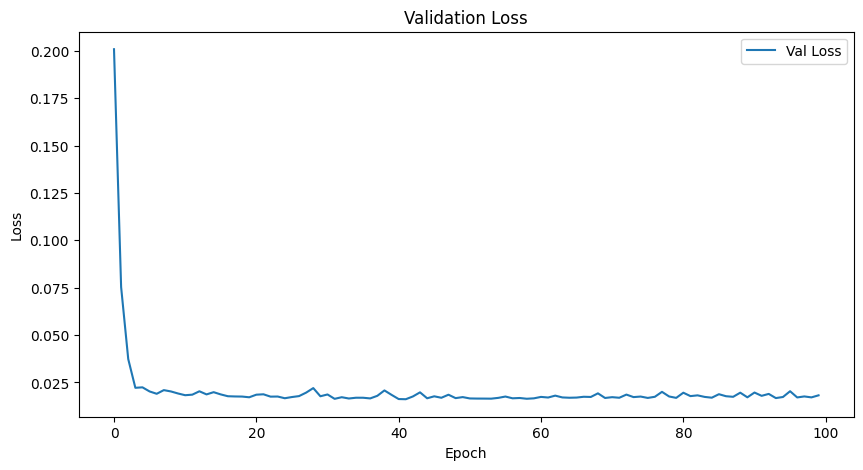

In [ ]:
# Visualize training history
plt.figure(figsize=(10, 5))
for i, fold_hist in enumerate(trainer.history):
    if fold_hist is not None:
        plt.plot(fold_hist["val_loss"], label="Val Loss")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Example: Setup TrainerConfig with Kfold for cross-validation
from sklearn.metrics import mean_squared_error, r2_score

trainer_config_cv = TrainerConfig(
    optimizer="adam",
    criterion="mse",
    batch_size=16,
    epochs=100,
    seed=11,
    config_model=mlp_config,
    learning_rate=0.001,
    device="cuda" if torch.cuda.is_available() else "cpu",
    cross_validation=True,
    n_splits=5,
    metrics=[mean_squared_error, r2_score],
)
trainer_cv = ModelTrainer(trainer_config_cv)

In [ ]:
# Train the MLP model using cross-validation (StratifiedKFold)
# This will run 5-fold cross-validation and store history for each fold in trainer_cv.history
trainer_cv.train(X_train_tensor, y_train_tensor)

Training fold 1/5


Training fold 2/5


Training fold 3/5


Training fold 4/5


Training fold 5/5


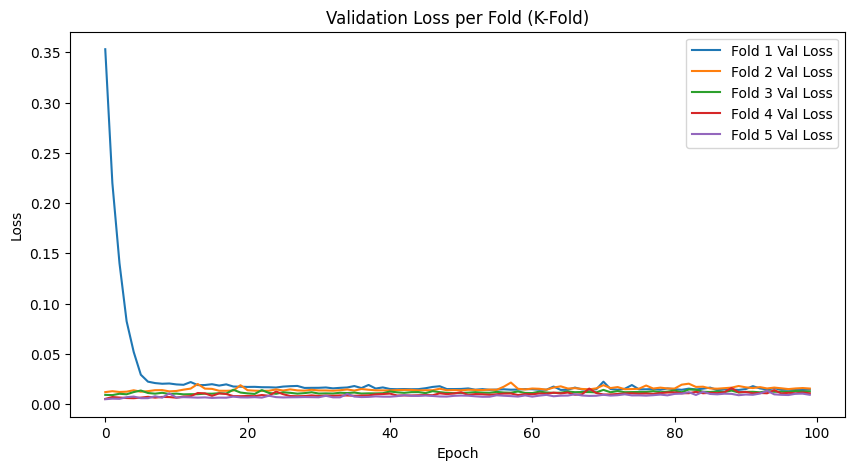

In [ ]:
# Visualize K-Fold training history for all folds
plt.figure(figsize=(10, 5))
for i, fold_hist in enumerate(trainer_cv.history):
    if fold_hist is not None:
        plt.plot(fold_hist["val_loss"], label=f"Fold {i + 1} Val Loss")
plt.title("Validation Loss per Fold (K-Fold)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()